In [1]:
%matplotlib inline

import os
import sys
import time
import pickle
import numpy as np
from matplotlib import pyplot as plt, ticker
from scipy import linalg
from pysar.simulation.plot import *
from pysar.simulation import simulation as sim
from pysar.objects import timeseries, ifgramStack, sensor
from pysar.utils import readfile, ptime, plot as pp, writefile, utils as ut, network as pnet
import pysar.ifgram_inversion as ifginv
#from pysar.unwrap_error_phase_closure import correct_unwrap_error_closure

work_dir = os.path.expandvars('$PNOTE/sim_phaseClosure')
os.chdir(work_dir)
print('Go to directory: '+work_dir)

# reference file
proj_dir = os.path.expanduser('~/insarlab/Galapagos/GalapagosSenDT128/PYSAR')
sensor_name = sensor.project_name2sensor_name(proj_dir)[0]
ts_file = os.path.join(proj_dir, 'timeseries.h5')
ts_obj = timeseries(ts_file)
ts_obj.open(print_msg=False)
ts_obj.save2bl_list_file(out_file='bl_list.txt')

# specified time-series
inc_angle = ut.incidence_angle(ts_obj.metadata, dimension=0, print_msg=False)
tbase = np.array(ts_obj.tbase)
ts_sim = sim.sim_variable_timeseries(tbase, display=False)

## Decorrelation Noise Setup
coh_resid, decor_time = 0.0, 200  # 0.0, 50; 0.1, 50; 0.0, 200; 0.2, 200; 0.4, 200

Go to directory: /Users/yunjunz/development/python/2019_RSE_PYSAR/sim_phaseClosure
write baseline list info to file: bl_list.txt


number of ifgrams: 3
number of triplets: 1
ifgram with unwrap error: 0.35
unwrap error jump in 2*pi*(-2, 2): 
number of ifgrams with unwrap error: 1
max perpendicular baseline: 62.84 m
max temporal      baseline: 84.0 days


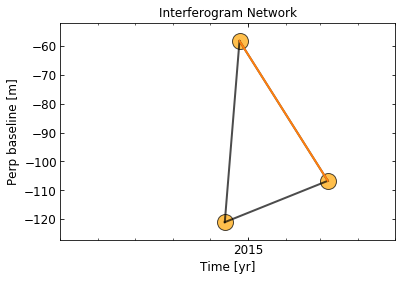

In [2]:
## Simulate interferograms with unwrapping errors

# temp/spatial baseline
date_list = ts_obj.dateList[:3]
pbase = ts_obj.pbase[:3]
dates = ptime.date_list2vector(date_list)[0]

# network setup
date12_list = pnet.select_pairs_sequential(date_list, num_connection=5, date12_format='YYYYMMDD_YYYYMMDD')
num_ifgram = len(date12_list)
C = ifgramStack.get_design_matrix4triplet(date12_list=date12_list)
print('number of ifgrams: {}'.format(num_ifgram))
print('number of triplets: {}'.format(C.shape[0]))

# simulate ifgram without unwrap error
ifgram, cor = sim.simulate_network(ts_sim, date12_list, decor_time, coh_resid, L=3*9, num_sample=1, baseline_file='bl_list.txt', sensor_name=sensor_name, inc_angle=inc_angle)[0:2]
ifgram = ifgram.flatten()
cor = cor.flatten()
# add unwrap error
ifgram_err, idx_ifg_err = sim.add_unw_err2ifgram(ifgram, percentage=0.35, Nmax=2, print_msg=True)

# plot
fig, ax = plt.subplots()
pp.plot_network(ax, date12_list, date_list, pbase)
# plot interferometric pairs with error
for date12 in np.array(date12_list)[idx_ifg_err]:
    date1, date2 = date12.split('_')
    idx1 = date_list.index(date1)
    idx2 = date_list.index(date2)
    x = [dates[idx1], dates[idx2]]
    y = [pbase[idx1], pbase[idx2]]
    ax.plot(x, y, '-', lw=2, alpha=1.0, c=pp.mplColors[1])
# axis format
pp.auto_adjust_xaxis_date(ax, dates, fontsize=font_size)
ax.set_xlabel('Time [yr]', fontsize=font_size)
ax.set_ylabel('Perp baseline [m]', fontsize=font_size)
plt.show()

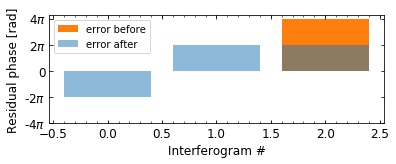

In [7]:
# correct unwrap error
Dconstraint = True
thres = 0.02 # cycles
alpha = 0.25

#ifgram_cor = correct_unwrap_error_closure(ifgram_err, C, Dconstraint=True, alpha=0.25)[0].flatten()
num_tri, num_ifgram = C.shape
ifgram_err = ifgram_err.reshape(num_ifgram, -1)

# integer ambiguity of the closure phase
closure_pha = np.dot(C, ifgram_err)
closure_int = (closure_pha - ut.wrap(closure_pha)) / (2.*np.pi)

# prepare design matrix
A = np.array(-1.*C, dtype=np.float32)
I = np.eye(num_ifgram, dtype=np.float32)
# Opt 1. Constraint on "unwrapping-error free" interferograms
if Dconstraint:
    idx_nonzero = (np.abs(closure_int) >= thres).flatten()
    idx_ifgram = np.sum(C[idx_nonzero, :] != 0., axis=0) == 0.
    D = I[idx_ifgram, :]
    A = np.vstack((A, D))
# Opt 2. Tikhonov regularization (alpha*D0) to solve equation in ill-posed scenario:
A = np.vstack((A, alpha*I))

# L2-norm optimization -> least squares estimation
U = np.zeros(ifgram_err.shape, np.float32)
try:
    A_inv = linalg.pinv2(A, rcond=1e-8)
    B = np.zeros((A.shape[0], ifgram_err.shape[1]), np.float32)
    B[0:num_tri, :] = closure_pha / (2.*np.pi)  #this gives better result than minimizing closure_int
    U = np.round(np.dot(A_inv, B))
except linalg.LinAlgError:
    pass
# corrected interferogram
ifgram_cor = ifgram_err + 2*np.pi*U
ifgram_err = ifgram_err.flatten()
ifgram_cor = ifgram_cor.flatten()

# plot
fig, ax = plt.subplots(figsize=[6, 2])
x = np.arange(num_ifgram)
ax.bar(x, ifgram_err - ifgram, color=pp.mplColors[1], label='error before')
ax.bar(x, ifgram_cor - ifgram, color=pp.mplColors[0], label='error after', alpha=0.5)
# axis format
ax.tick_params(which='both', direction='in', labelsize=font_size, bottom=True, top=True, left=True, right=True)
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.set_yticks([-4*np.pi, -2*np.pi, 0, 2*np.pi, 4*np.pi])
ax.set_yticklabels([r'-4$\pi$', r'-2$\pi$', '0', r'2$\pi$', r'4$\pi$'])
ax.set_xlabel('Interferogram #', fontsize=font_size)
ax.set_ylabel('Residual phase [rad]', fontsize=font_size)
#ax.set_xlim(0, ifgram.shape[0])
plt.legend()
plt.show()

In [8]:
date12_list, ifgram, cor

(['20141213_20141225', '20141213_20150307', '20141225_20150307'],
 array([0.11852357, 0.65156746, 0.48256183], dtype=float32),
 array([1., 1., 1.], dtype=float32))

In [9]:
ifgram_err, closure_pha, closure_int

(array([ 0.11852357,  0.65156746, 13.048932  ], dtype=float32),
 array([[12.515888]], dtype=float32),
 array([[2.]], dtype=float32))

In [8]:
def correct_unwrap_error_closure(ifgram, C, Dconstraint=True, thres=0.02, alpha=0.25):
    num_tri, num_ifgram = C.shape
    ifgram = ifgram.reshape(num_ifgram, -1)
    
    # integer ambiguity of the closure phase
    closure_pha = np.dot(C, ifgram)
    closure_int = (closure_pha - ut.wrap(closure_pha)) / (2.*np.pi)
    
    # prepare design matrix
    A = np.array(-1.*C, dtype=np.float32)
    I = np.eye(num_ifgram, dtype=np.float32)
    # Opt 1. Constraint on "unwrapping-error free" interferograms
    if Dconstraint:
        idx_nonzero = (closure_int >= thres).flatten()
        idx_ifgram = np.sum(C[idx_nonzero, :] != 0., axis=0) == 0.
        D = I[idx_ifgram, :]
        A = np.vstack((A, D))
    # Opt 2. Tikhonov regularization (alpha*D0) to solve equation in ill-posed scenario:
    A = np.vstack((A, alpha*I))
    
    # L2-norm optimization -> least squares estimation
    U = np.zeros(ifgram.shape, np.float32)
    try:
        A_inv = linalg.pinv2(A, rcond=1e-8)
        B = np.zeros((A.shape[0], ifgram.shape[1]), np.float32)
        B[0:num_tri, :] = closure_pha / (2.*np.pi)  #this gives better result than minimizing closure_int
        U = np.round(np.dot(A_inv, B))
    except linalg.LinAlgError:
        pass
    # corrected interferogram
    ifgram_cor = ifgram + 2*np.pi*U
    ifgram = ifgram.flatten()
    ifgram_cor = ifgram_cor.flatten()
    return ifgram_cor